In [1]:
# Libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import deconomix as dcx
from scipy.stats import spearmanr, pearsonr
from eval_functions import create_composition_overview, create_performance_overview

In [2]:
# Ct label aggregation DISCO
ct_aggregation = pd.read_csv('../Data/DISCO/cell_type_aggregation.csv')
ct_major = dict(zip(ct_aggregation['Cell type (DISCO)'], ct_aggregation['Cell type (major)']))
ct_minor = dict(zip(ct_aggregation['Cell type (DISCO)'], ct_aggregation['Cell type (minor)']))

# Data Import
print("Importing Data")
disco_healthy = pd.read_pickle('../Data/Preprocessed/disco_healthy_norm.pkl')
tcga_bulks   = pd.read_pickle('../Data/Preprocessed/tcga_conv_norm.pkl')
subtype = pd.read_csv('../Data/Preprocessed/tcga_subtype.csv').values.flatten()

Importing Data


In [3]:
# Select major labels
disco_healthy.columns = disco_healthy.columns.map(ct_major)

In [4]:
print("Loading cached artificial bulks")
X_ref = pd.read_pickle('../Data/Preprocessed/X_ref.pkl')
Y_train = pd.read_pickle('../Data/Preprocessed/Y_train.pkl')
C_train = pd.read_pickle('../Data/Preprocessed/C_train.pkl')

Loading cached artificial bulks


Training DTD model...


  0%|          | 0/1000 [00:00<?, ?it/s]

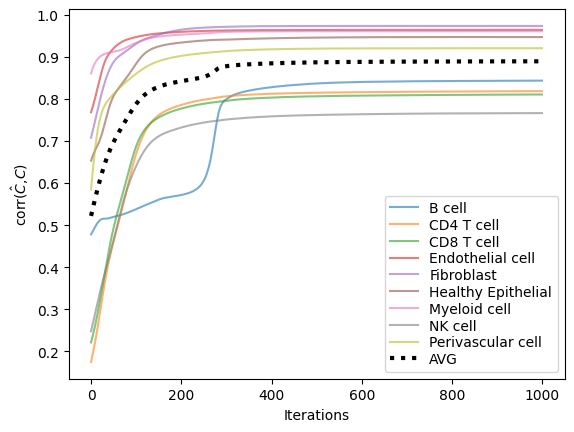

In [5]:
# Train a DTD model
print("Training DTD model...")
model_DTD = dcx.methods.DTD(X_ref, Y_train, C_train)
model_DTD.run(plot=True)

In [6]:
# Prepare Subtype Datasets
tcga_LumA = tcga_bulks.loc[:, subtype=='LumA'].astype(np.float64)
tcga_LumB = tcga_bulks.loc[:, subtype=='LumB'].astype(np.float64)
tcga_Her2 = tcga_bulks.loc[:, subtype=='Her2'].astype(np.float64)
tcga_Basal = tcga_bulks.loc[:, subtype=='Basal'].astype(np.float64)

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def calc_terms(X_ref, Y_test, gamma, C_est, x_est, c_est, Delta_est):
    G = np.diag(gamma.values.flatten())
    Y = Y_test.values
    X = X_ref.values
    C = C_est.values
    x = x_est.values
    c = c_est.values
    Delta = Delta_est.values

    term1 = np.linalg.norm(G @ (Y - (Delta * X) @ C - x @ c), 'fro')**2
    term2 = np.linalg.norm(np.ones_like(Delta) - Delta, 'fro')**2
    return term1, term2

In [17]:
# Define log scale range for lambda2
lambda2_range = np.logspace(-10, 0, num=11)

term1s = []
term2s = []

for l2 in lambda2_range:
    print(f"Training ADTD with lambda2={l2}")
    model_ADTD = dcx.methods.ADTD(X_ref, tcga_Basal, model_DTD.gamma, C_static=True, Delta_static=False, lambda2=l2)
    model_ADTD.run()
    term1, term2 = calc_terms(X_ref, tcga_Basal, model_DTD.gamma, model_ADTD.C_est, model_ADTD.x_est, model_ADTD.c_est, model_ADTD.Delta_est)
    term1s.append(term1)
    term2s.append(term2)

Training ADTD with lambda2=1e-10


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-09


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-08


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-07


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-06


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=9.999999999999999e-06


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.0001


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.001


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.01


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.1


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1.0


  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
import pandas as pd

# Save term1s, term2s, and lambda2_range to a CSV named for the subtype
results_df = pd.DataFrame({
    "lambda2": lambda2_range,
    "term1": term1s,
    "term2": term2s
})
results_df.to_csv("Outputs/L-Curves/L-Curve_Basal.csv", index=False)


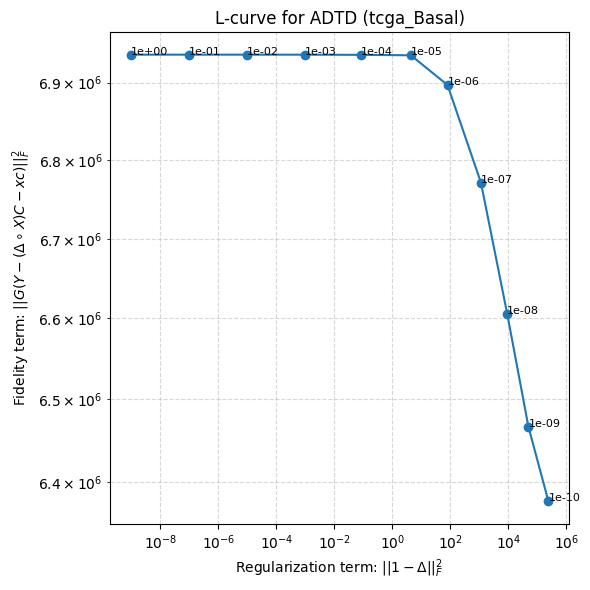

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(term2s, term1s, marker='o')
for i, l2 in enumerate(lambda2_range):
    plt.annotate(f"{l2:.0e}", (term2s[i], term1s[i]), fontsize=8)
plt.xlabel(r"Regularization term: $||1-\Delta||_F^2$")
plt.ylabel(r"Fidelity term: $||G(Y - (\Delta \circ X)C - xc)||_F^2$")
plt.title("L-curve for ADTD (tcga_Basal)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


L-Curve: Balancing data fidelity and deviation of $\Delta$ from its prior structure $J_{p,q} = 1$ to find the best compromise between overfitting and over-regularization. The 'corner' in the plot corresponds to the weakest constraint on $\Delta$ that still prevents it from overfitting the data.

In [35]:
def calc_l_curve_for_subtype(X_ref, tcga_data, model_DTD, subtype_name, lambda2_range=None, out_dir="Outputs/L-Curves"):
    """
    Calculates and saves the L-curve (fidelity vs regularization) for ADTD on a single subtype.

    Parameters:
        X_ref (pd.DataFrame): Reference matrix.
        tcga_data (pd.DataFrame): Bulk expression matrix for a given subtype.
        model_DTD: Fitted DTD model (used for gamma, etc).
        subtype_name (str): Name of the subtype (used for output files).
        lambda2_range (array-like or None): Lambda2 values to test, or None for default.
        out_dir (str): Output directory to save the CSV.
    Returns:
        pd.DataFrame with entries for each lambda2, term1, term2.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import os

    if lambda2_range is None:
        lambda2_range = np.logspace(-10, 0, num=11)
    else:
        lambda2_range = np.array(lambda2_range)

    term1s = []
    term2s = []

    for l2 in lambda2_range:
        print(f"Training ADTD with lambda2={l2} for subtype {subtype_name}")
        model_ADTD = dcx.methods.ADTD(
            X_ref, tcga_data, model_DTD.gamma, 
            C_static=True, Delta_static=False, lambda2=l2
        )
        model_ADTD.run()
        term1, term2 = calc_terms(
            X_ref, tcga_data, model_DTD.gamma, 
            model_ADTD.C_est, model_ADTD.x_est, model_ADTD.c_est, model_ADTD.Delta_est
        )
        term1s.append(term1)
        term2s.append(term2)

    # Save to CSV
    os.makedirs(out_dir, exist_ok=True)
    results_df = pd.DataFrame({
        "lambda2": lambda2_range,
        "term1": term1s,
        "term2": term2s
    })
    csv_path = os.path.join(out_dir, f"L-Curve_{subtype_name}.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"L-curve results saved to: {csv_path}")
    return results_df

# Optionally, plot the L-curve using a separate function.
def plot_L_curve(results_df, subtype_name):
    import matplotlib.pyplot as plt
    term2s = results_df['term2'].values
    term1s = results_df['term1'].values
    lambda2_range = results_df['lambda2'].values
    plt.figure(figsize=(6,6))
    plt.plot(term2s, term1s, marker='o')
    for i, l2 in enumerate(lambda2_range):
        plt.annotate(f"{l2:.0e}", (term2s[i], term1s[i]), fontsize=8)
    plt.xlabel(r"Regularization term: $||1-\Delta||_F^2$")
    plt.ylabel(r"Fidelity term: $||G(Y - (\Delta \circ X)C - xc)||_F^2$")
    plt.title(f"L-curve for ADTD ({subtype_name})")
    plt.xscale("log")
    plt.yscale("log")
    plt.grid(True, which='both', ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()



In [37]:
results_LumB = calc_l_curve_for_subtype(X_ref, tcga_LumB, model_DTD, "LumB")

Training ADTD with lambda2=1e-10 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-09 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-08 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-07 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-06 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=9.999999999999999e-06 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.0001 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.001 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.01 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.1 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1.0 for subtype LumB


  0%|          | 0/200 [00:00<?, ?it/s]

L-curve results saved to: Outputs/L-Curves/L-Curve_LumB.csv


In [38]:
results_LumA = calc_l_curve_for_subtype(X_ref, tcga_LumA, model_DTD, "LumA")







Training ADTD with lambda2=1e-10 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-09 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-08 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-07 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-06 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=9.999999999999999e-06 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.0001 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.001 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.01 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.1 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1.0 for subtype LumA


  0%|          | 0/200 [00:00<?, ?it/s]

L-curve results saved to: Outputs/L-Curves/L-Curve_LumA.csv


In [39]:
results_Her2 = calc_l_curve_for_subtype(X_ref, tcga_Her2, model_DTD, "Her2")

Training ADTD with lambda2=1e-10 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-09 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-08 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-07 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1e-06 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=9.999999999999999e-06 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.0001 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.001 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.01 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=0.1 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

Training ADTD with lambda2=1.0 for subtype Her2


  0%|          | 0/200 [00:00<?, ?it/s]

L-curve results saved to: Outputs/L-Curves/L-Curve_Her2.csv


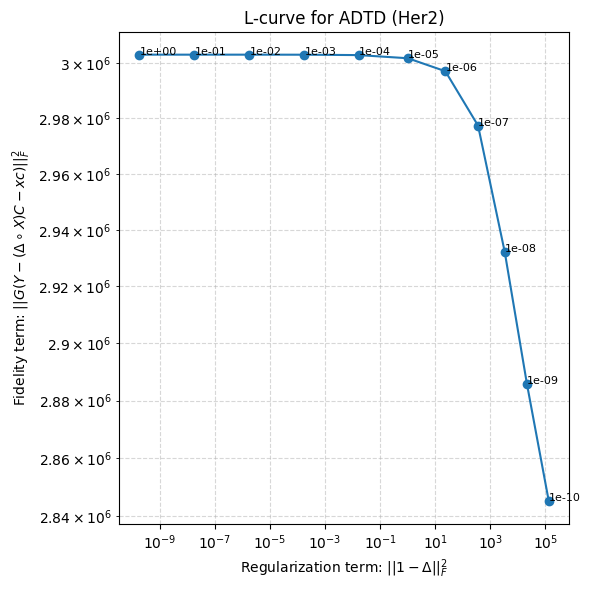

In [40]:
plot_L_curve(results_Her2, "Her2")

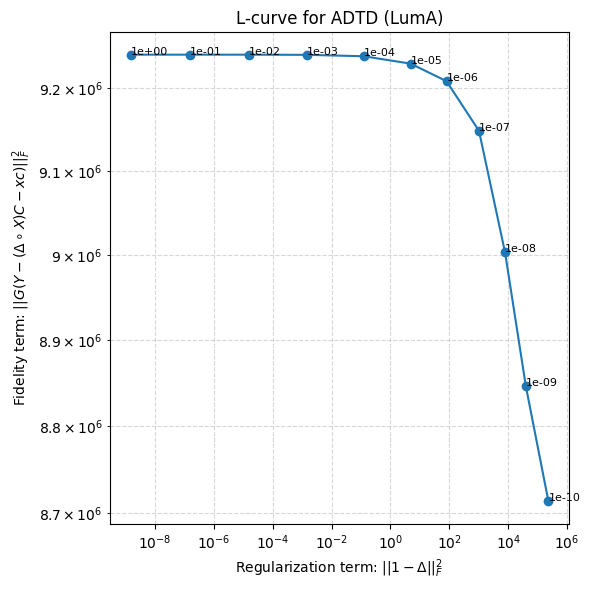

In [41]:
plot_L_curve(results_LumA, "LumA")

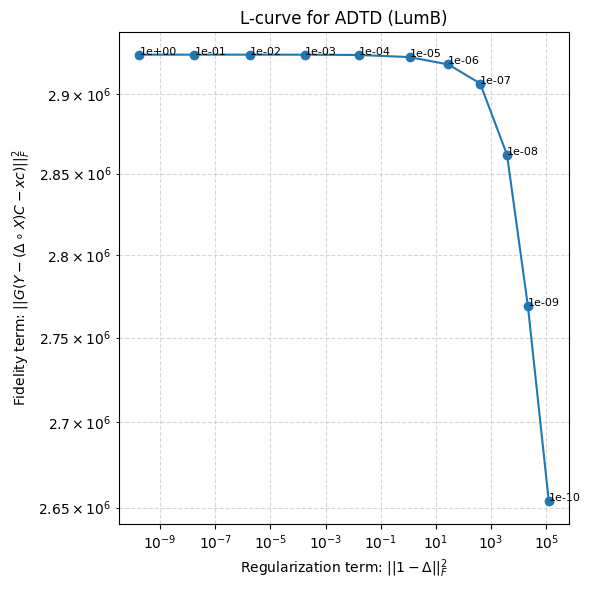

In [42]:
plot_L_curve(results_LumB, "LumB")

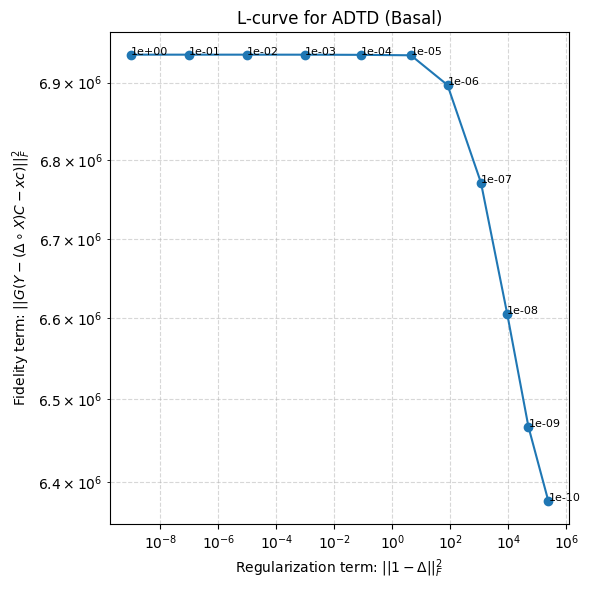

In [43]:
plot_L_curve(results_df, "Basal")